# TP CLASSIFICATION

In [289]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import img_to_array
import matplotlib.image as mpimg
from skimage import transform

## 1. Chargement et exploration du dataset

In [290]:
# Chargement du dataset depuis le répertoire
base_dir = './PetImagesGray/'
img_width, img_height = 200, 200
Batch_Size = 64

train_datagen = image_dataset_from_directory(
    base_dir,
    image_size=(img_height, img_width),
    subset='training',
    seed=1,
    validation_split=0.1,
    batch_size=Batch_Size,
    color_mode='grayscale'  # Spécifier que les images sont en niveaux de gris
)

test_datagen = image_dataset_from_directory(
    base_dir,
    image_size=(img_height, img_width),
    subset='validation',
    seed=1,
    validation_split=0.1,
    batch_size=Batch_Size,
    color_mode='grayscale'  # Spécifier que les images sont en niveaux de gris
)

Found 800 files belonging to 2 classes.
Using 720 files for training.


Found 800 files belonging to 2 classes.
Using 80 files for validation.


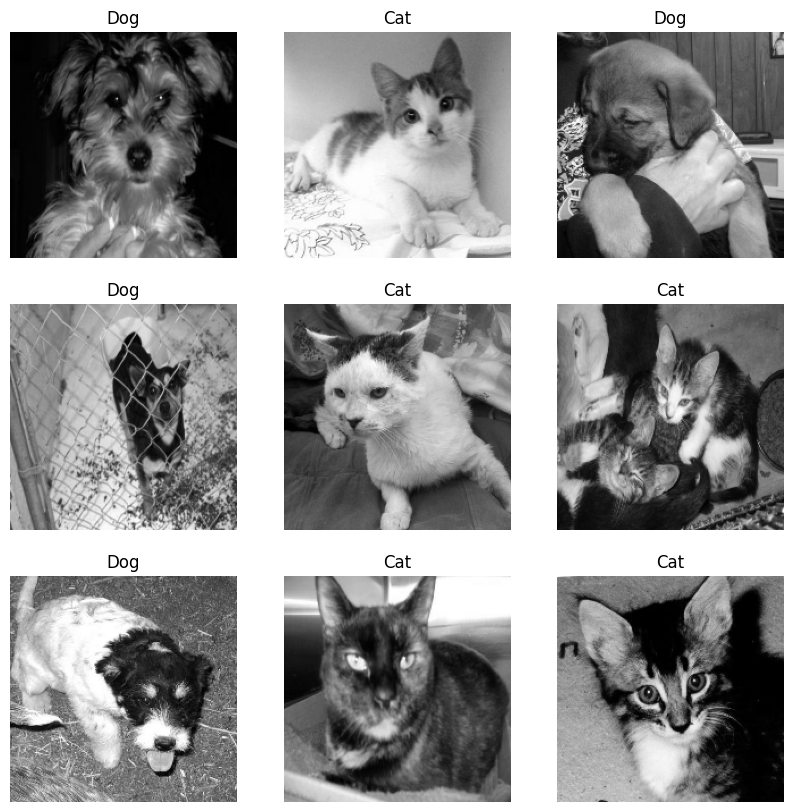

In [291]:
# Affichage de quelques exemples d'images du dataset
# TODO: Visualiser 9 images avec leurs labels
class_names = train_datagen.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_datagen.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 2. Préparation des données

In [292]:
# Normalisation des données
# TODO: Normaliser les pixels entre 0 et 1
normalization_layer = layers.Rescaling(1./255)
train_datagen = train_datagen.map(lambda x, y: (normalization_layer(x), y))
test_datagen = test_datagen.map(lambda x, y: (normalization_layer(x), y))

## 3. Construction du modèle CNN

In [293]:
# Définition de l'architecture du modèle
# TODO: Créer un modèle Sequential avec des couches Conv2D, MaxPooling2D, Flatten, Dense

model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

c:\Users\alexi\Documents\GitHub\RDN-YGREG-TP1\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [294]:
# Compilation du modèle
# TODO: Compiler avec optimizer, loss et metrics appropriés

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [295]:
# Affichage du résumé du modèle
# TODO: model.summary()

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     8,667,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,760,194 (33.42 MB)

 Trainable params: 8,760,194 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Entraînement du modèle

In [296]:
# Entraînement du modèle
# TODO: Entraîner le modèle avec model.fit()
Nb_epochs = 10
history = model.fit(train_datagen, epochs=Nb_epochs,validation_data=test_datagen)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 858ms/step - accuracy: 0.4889 - loss: 0.8934 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 845ms/step - accuracy: 0.4833 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6939
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 917ms/step - accuracy: 0.5028 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6937
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 849ms/step - accuracy: 0.5028 - loss: 0.6922 - val_accuracy: 0.4750 - val_loss: 0.6936
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 862ms/step - accuracy: 0.5028 - loss: 0.6902 - val_accuracy: 0.4750 - val_loss: 0.6993
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 881ms/step - accuracy: 0.5375 - loss: 0.6891 - val_accuracy: 0.5250 - val_loss: 0.6904
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 868ms/step - accuracy: 0.5375 - loss: 0.6860 - val_accuracy: 0.4625 - val_loss: 0.6878
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 849ms/step - accuracy: 0.5292 - loss: 0.6781 - val_accu

## 5. Évaluation et visualisation des résultats

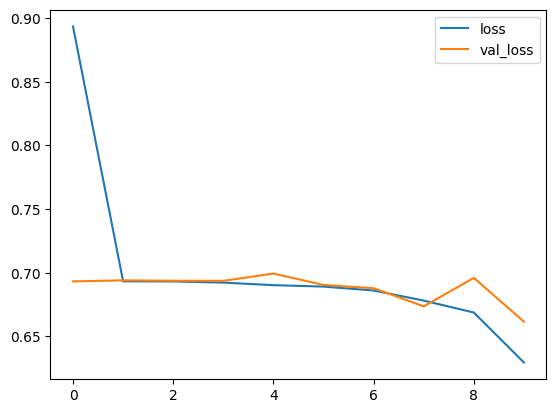

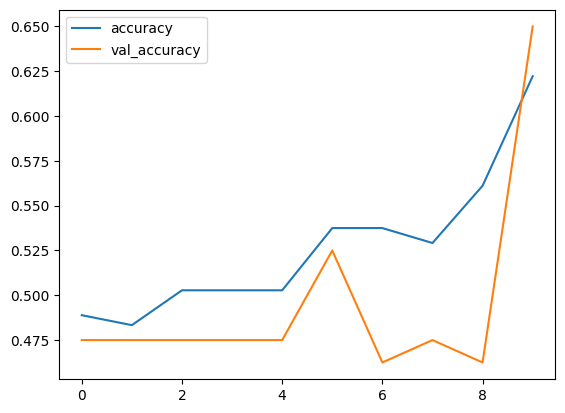

In [314]:
# Visualisation des courbes d'apprentissage (loss et accuracy)
# TODO: Tracer les courbes de loss et accuracy pour train et validation
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [298]:
# Évaluation sur l'ensemble de test

test_loss, test_accuracy = model.evaluate(test_datagen)
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6500 - loss: 0.6615

Test Loss: 0.6615
Test Accuracy: 0.6500


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


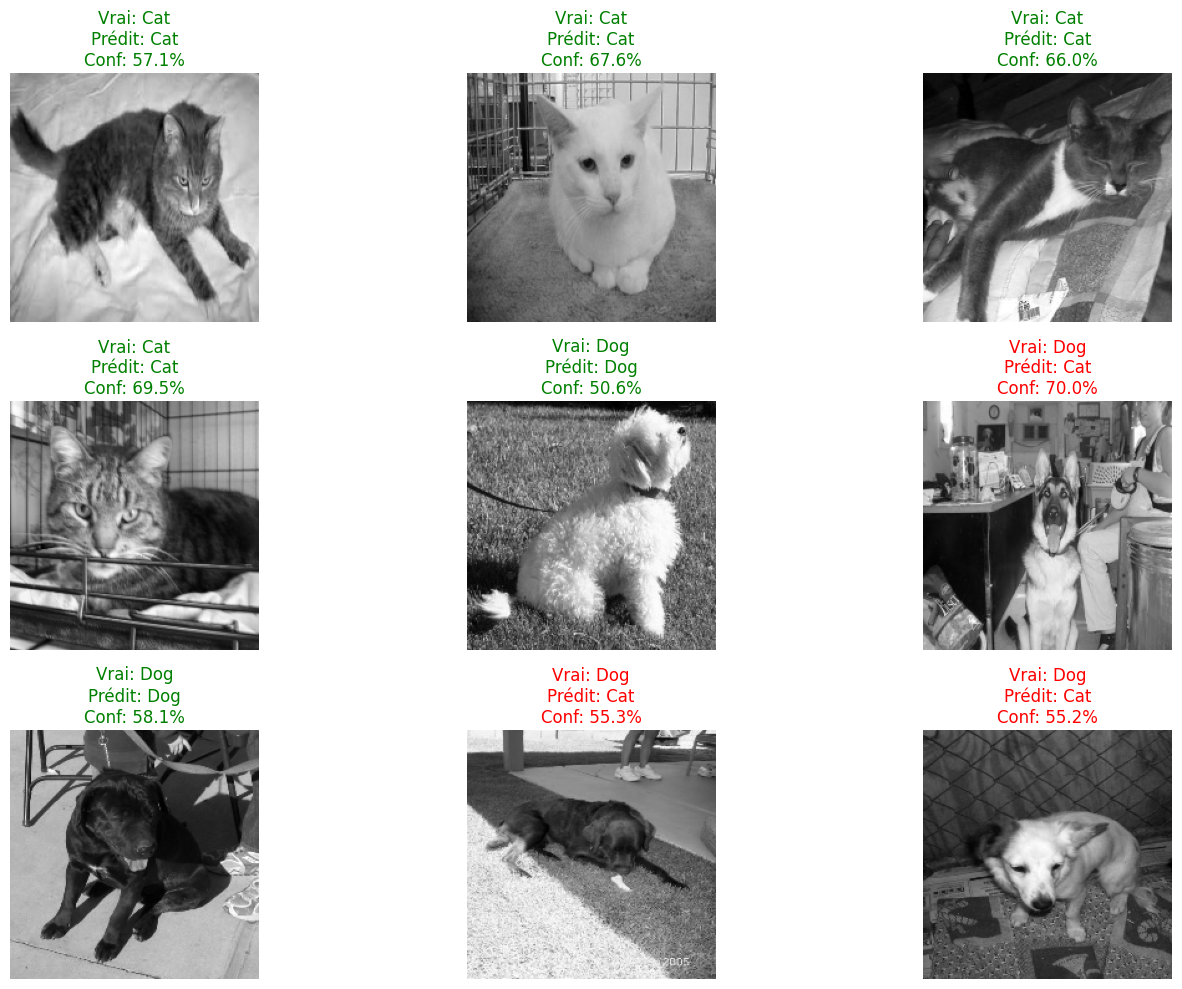

In [299]:
# Prédictions sur quelques images de test

plt.figure(figsize=(15, 10))
for images, labels in test_datagen.take(1):
    predictions = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        
        predicted_class = class_names[np.argmax(predictions[i])]
        true_class = class_names[labels[i]]
        confidence = np.max(predictions[i]) * 100
        
        color = 'green' if predicted_class == true_class else 'red'
        plt.title(f'Vrai: {true_class}\nPrédit: {predicted_class}\nConf: {confidence:.1f}%', 
                  color=color)
        plt.axis("off")
plt.tight_layout()
plt.show()

## 5.5 Prédiction sur des images individuelles

In [300]:
# Import de skimage pour le redimensionnement
from skimage import transform

def predict_image(image_path):
    # Charger l'image
    img = mpimg.imread(image_path)
    
    # Redimensionner l'image si nécessaire
    if img.shape[0] != img_height or img.shape[1] != img_width:
        img = img[0:img_height, 0:img_width] if img.shape[0] >= img_height and img.shape[1] >= img_width else img
    
    # Afficher l'image
    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    # Convertir en array et normaliser
    img = img_to_array(img)
    
    # Pour les images en niveaux de gris, s'assurer qu'elles ont la bonne forme
    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)
    
    # Redimensionner à la taille attendue
    img = transform.resize(img, (img_height, img_width, 1))
    
    # Normaliser les pixels entre 0 et 1
    img = img / 255.0 if img.max() > 1 else img
    
    # Ajouter la dimension batch
    img = np.expand_dims(img, axis=0)
    
    # Prédire
    result = model.predict(img, batch_size=1, verbose=0)
    print(f"Prédictions brutes: {result}")
    
    # Obtenir la classe prédite
    predicted_class_idx = np.argmax(result[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = result[0][predicted_class_idx] * 100
    
    print(f"Classe prédite: {predicted_class} (Confiance: {confidence:.2f}%)")
    
    return predicted_class, confidence

=== Prédiction sur une image de chat ===


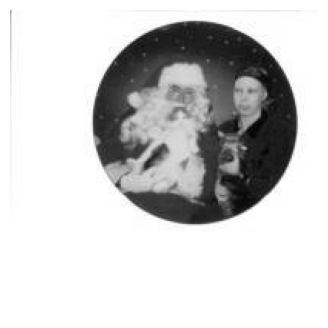

Prédictions brutes: [[0.60544693 0.3945531 ]]
Classe prédite: Cat (Confiance: 60.54%)

=== Prédiction sur une image de chien ===


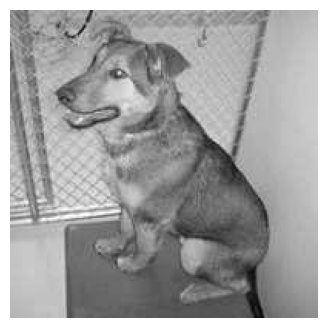

Prédictions brutes: [[0.5733525  0.42664745]]
Classe prédite: Cat (Confiance: 57.34%)


('Cat', np.float32(57.33525))

In [301]:
# Test de prédiction sur des images individuelles
print("=== Prédiction sur une image de chat ===")
predict_image(base_dir + 'Cat/35.jpg')

print("\n=== Prédiction sur une image de chien ===")
predict_image(base_dir + 'Dog/25.jpg')

## 6. Amélioration du modèle

In [302]:
# Data augmentation
# TODO: Ajouter des couches de data augmentation (RandomFlip, RandomRotation, etc.)

In [303]:
# Modèle amélioré avec data augmentation et dropout
# TODO: Créer un nouveau modèle avec augmentation et régularisation

In [304]:
# Entraînement du modèle amélioré
# TODO: Entraîner le modèle amélioré

In [305]:
# Comparaison des performances
# TODO: Comparer les résultats des deux modèles

## 7. Matrice de confusion

In [306]:
# Calcul et affichage de la matrice de confusion
# TODO: Créer et afficher la matrice de confusion

## 8. Sauvegarde du modèle

In [307]:
# Sauvegarde du modèle entraîné
# TODO: Sauvegarder le modèle avec model.save()

## 9. Validation croisée K-Fold

In [308]:
# Import des bibliothèques pour la validation croisée
from sklearn.model_selection import KFold
import numpy as np

# TODO: Préparer les données pour la validation croisée
# Convertir les datasets en numpy arrays

In [309]:
# Configuration de la validation croisée
# TODO: Définir le nombre de folds (k=5 par exemple)
# TODO: Initialiser KFold
# TODO: Créer une liste pour stocker les scores

In [310]:
# Fonction pour créer le modèle
def create_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [311]:
# Exécution de la validation croisée
# TODO: Boucle sur chaque fold
# TODO: Entraîner le modèle sur chaque fold
# TODO: Évaluer et stocker les résultats

In [312]:
# Affichage des résultats de la validation croisée
# TODO: Calculer et afficher la moyenne et l'écart-type des scores
# TODO: Créer un graphique en barres des scores par fold

In [313]:
# Comparaison avec le modèle amélioré (avec data augmentation)
# TODO: Répéter la validation croisée avec le modèle amélioré
# TODO: Comparer les résultats moyens des deux approches